In [1]:
import numpy as np

import random
import h5py
from keras.models import *
from keras.layers import *
from keras.layers.core import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.regularizers import *
from keras.initializers import *
from keras.models import load_model
import theano.tensor as T
import theano
from sklearn import metrics
from sklearn.preprocessing import *
from scipy.fftpack import dct, idct

import os
import random
import time
import matplotlib
import matplotlib.pyplot as plt
import glob

import operator
import math
import re

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

# increase recursion limit for adaptive VQ
import sys
sys.setrecursionlimit(40000)

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 690 (CNMeM is disabled, cuDNN 5105)


In [2]:
# external custom code I wrote
from load_data import *
from windowing import *
from utility import *
from pesq import *
from noise import *
from consts import *
from nn_blocks import *
from transforms import *

In [3]:
# randomly shuffle data before partitioning into training/validation?
RANDOM_SHUFFLE = True

# number of speech files for train, val, and test
TRAIN_SIZE = 1000
VAL_SIZE = 100
TEST_SIZE = 500

# during training, we evaluate PESQ and RMSE and such on full speech files every epoch, which
# is kind of expensive. so instead of selecting the full training and validation set, we
# randomly select this many waveforms
TRAIN_EVALUATE = 50
VAL_EVALUATE = 50

In [4]:
[train_paths, val_paths, test_paths], \
[train_waveforms, val_waveforms, test_waveforms], \
[train_procwave, val_procwave, test_procwave], \
[train_wparams, val_wparams, test_wparams], \
[train_windows, val_windows, test_windows] = load_data(TRAIN_SIZE, VAL_SIZE, TEST_SIZE)

In [5]:
# flatten all of the train windows into vectors
train_processed = np.array([i for z in train_windows for i in z])
train_processed = np.reshape(train_processed, (train_processed.shape[0], WINDOW_SIZE, 1))

# randomly shuffle data, if we want to
if (RANDOM_SHUFFLE):
    train_processed = np.random.permutation(train_processed)
    
print train_processed.shape
print np.mean(train_processed, axis=None)
print np.std(train_processed, axis=None)
print np.min(train_processed, axis = None)
print np.max(train_processed, axis = None)

(101814, 512, 1)
6.41179e-06
0.103588
-1.0
1.0


In [6]:
input_dim = (WINDOW_SIZE, 1)

In [7]:
from keras.activations import softmax
from sklearn.cluster import KMeans, MiniBatchKMeans

# softmax hardness variable
tau = K.variable(256.0, name = "hardness")
tau_mult_rate = 2.0
max_tau = 256.0

NBINS = 256
VEC_SIZE = 4

# initially, quantization is not on
QUANT_BINS = K.zeros((NBINS, VEC_SIZE))
QUANTIZATION_ON = K.variable(False)

GAINS = K.variable(np.random.uniform(0.99, 1.01, (NBINS,)))
BIASES = K.variable(np.random.uniform(-0.01, 0.01, (NBINS,)))

DOWNSAMPLE_FACTOR = 2
CHANNEL_SIZE = WINDOW_SIZE / DOWNSAMPLE_FACTOR

In [8]:
def unquantize_batch(one_hot):
    out = T.tensordot(one_hot, QUANT_BINS, axes = [2, 0])
    out = K.reshape(out, (out.shape[0], out.shape[1] * VEC_SIZE))
    return out

def unquantize_vec(one_hot):
    out = T.tensordot(one_hot, QUANT_BINS, axes = [1, 0])
    out = K.reshape(out, (CHANNEL_SIZE,))
    return out

class SoftmaxQuantization(Layer):
    def __init__(self, **kwargs):
        super(SoftmaxQuantization, self).__init__(**kwargs)
   
    def build(self, input_shape):
        self.trainable_weights = [QUANT_BINS]
        super(SoftmaxQuantization, self).build(input_shape)
        
    def call(self, x, mask=None):
        # x is an array: [BATCH x WINDOW_SIZE]
        
        # first, compute side info (mean and std)
        #     result: [BATCH x 2] tensor
        #             1st index is mean, 2nd is std
        x_mean = K.mean(x, axis = 1)
        x_std = K.std(x, axis = 1)
        side_info = K.stack([x_mean, x_std], axis = 1)
        
        # normalize x
        x_mean_expand = K.repeat_elements(K.expand_dims(x_mean, axis = 1), \
                                          x.shape[1], 1)
        x_std_expand = K.repeat_elements(K.expand_dims(x_std, axis = 1), \
                                          x.shape[1], 1)
        norm_x = (x - x_mean_expand) / x_std_expand
        
        # x_r becomes: [BATCH x (WINDOW_SIZE / VEC_SIZE) x NBINS x VEC_SIZE]
        x_r = K.reshape(norm_x, (-1, norm_x.shape[1] / VEC_SIZE, 1, VEC_SIZE))
        x_r = K.repeat_elements(x_r, QUANT_BINS.shape[0], -2)

        # quant_bins is an array: [NBINS x VEC_SIZE] 
        # q_r becomes: [BATCH x (WINDOW_SIZE / VEC_SIZE) x NBINS x VEC_SIZE]
        q_r = K.reshape(QUANT_BINS, (1, 1, QUANT_BINS.shape[0], VEC_SIZE))
        q_r = K.repeat_elements(q_r, x_r.shape[0], 0)
        q_r = K.repeat_elements(q_r, x_r.shape[1], 1)

        # get L2 distance from each element to each of the bins
        dist = K.sqrt(K.sum(K.square(x_r - q_r), axis = -1) + K.epsilon())

        # turn into softmax probabilities, which we return
        probs = softmax(tau * -dist)
        
        # if quantization isn't on yet, we just return the original vector x, reshaped
        # and padded to the right shape
        #     (this is a bad hack and I hope there is a better way to do this)
        quant_on = probs
        quant_off = K.zeros_like(quant_on)
        quant_off = T.set_subtensor(quant_off[:, :, :VEC_SIZE],
                                    K.reshape(x, (-1, x.shape[1] / VEC_SIZE, VEC_SIZE)))
        
        return [K.switch(QUANTIZATION_ON, quant_on, quant_off), side_info]
    
    def compute_output_shape(self, input_shape):
        return [(input_shape[0], input_shape[1] / VEC_SIZE, NBINS), (input_shape[0], 2)]
    
    def compute_mask(self, x, mask = None):
        return [None] * 2


class SoftmaxDequantization(Layer):
    def __init__(self, **kwargs):
        super(SoftmaxDequantization, self).__init__(**kwargs)
        self.supports_masking = False
    
    def build(self, input_shape):
        self.trainable_weights = []
        super(SoftmaxDequantization, self).build(input_shape)
        
    def call(self, x, mask=None):
        vecs = x[0]
        side_info = x[1]
        
        # extract mean and std from side info
        x_mean = side_info[:, 0]
        x_std = side_info[:, 1]
        
        out = T.tensordot(vecs, QUANT_BINS, axes = [2, 0])
        out = K.reshape(out, (out.shape[0], out.shape[1] * VEC_SIZE))
        
        # un-normalize output with side info
        x_mean_expand = K.repeat_elements(K.expand_dims(x_mean, axis = 1), \
                                          out.shape[1], 1)
        x_std_expand = K.repeat_elements(K.expand_dims(x_std, axis = 1), \
                                          out.shape[1], 1)
        out = (out * x_std_expand) + x_mean_expand
        
        quant_on = out
        quant_off = K.reshape(vecs[:, :, :VEC_SIZE], (-1, vecs.shape[1] * VEC_SIZE))
        return K.switch(QUANTIZATION_ON, quant_on, quant_off)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][1] * VEC_SIZE)

In [9]:
NUM_MFCC_COEFFS = 16

# precompute Mel filterbank
MEL_FILTERBANK_NPY = melFilterBank(NUM_MFCC_COEFFS).transpose()
MEL_FILTERBANK = K.variable(MEL_FILTERBANK_NPY)

# we precompute matrices for MFCC calculation
MFCC_DFT_REAL, MFCC_DFT_IMAG = generate_dft_mats(WINDOW_SIZE)
MFCC_DCT = generate_dct_mat(NUM_MFCC_COEFFS, norm = 'ortho')

# given a (symbolic Theano) array of size M x WINDOW_SIZE (or M x WINDOW_SIZE x 1)
#     this returns an array M x NUM_MFCC_COEFFS where each window has been replaced
#     by its MFCC coeffs
def theano_mfcc(x):
    powerSpectrum = T.pow(theano_dft_mag(x, MFCC_DFT_REAL, MFCC_DFT_IMAG), 2)
    
    filteredSpectrum = T.tensordot(powerSpectrum, MEL_FILTERBANK, axes = 1)

    logSpectrum = T.log(filteredSpectrum + K.epsilon())
    #mfccs = theano_dct(filteredSpectrum, MFCC_DCT)
    return logSpectrum

# compute MFCC for single window (Numpy)
def mfcc(signal):
    complexSpectrum = fft(signal)
    
    powerSpectrum = abs(complexSpectrum) ** 2
    filteredSpectrum = np.dot(powerSpectrum, MEL_FILTERBANK_NPY)

    # get log spectrum and take DCT to get MFCC
    logSpectrum = np.log(filteredSpectrum + np.finfo(float).eps)
    #mfcc = dct(logSpectrum, type=2)

    return logSpectrum

# mfcc loss function
def mfcc_distance(y_true, y_pred):
    mfcc_true = theano_mfcc(y_true)
    mfcc_pred = theano_mfcc(y_pred)
    return rmse(mfcc_true, mfcc_pred)

In [10]:
# increase number of channels from from_chan to num_chans via convolution
def channel_change_block(to_chan, filt_size, last_activ = True, dilation = 1):
    def f(input):
        res = Conv1D(to_chan, filt_size, padding = 'same',
                     kernel_initializer = W_INIT,
                     activation = 'linear',
                     dilation_rate = dilation)(input)
        res = activation()(res)
        res = Conv1D(to_chan, filt_size, padding = 'same',
                     kernel_initializer = W_INIT,
                     activation = 'linear',
                     dilation_rate = dilation)(res)
        if (last_activ):
            res = activation()(res)
        
        return res
        
    return f

In [11]:
# ---------------------------------------------------------------------------
# autoencoder: takes an audio window, compresses it, and tries to reconstruct it
# ---------------------------------------------------------------------------
def autoencoder_structure(dim):   
    # - - - - - - - - - - - - - - - - - - - - -
    # parameters
    # - - - - - - - - - - - - - - - - - - - - -   
    NCHAN = 32
    FILT_SIZE = 15

    # - - - - - - - - - - - - - - - - - - - - -
    # encoder
    # - - - - - - - - - - - - - - - - - - - - -
    enc_input = Input(shape = dim)
    enc = enc_input
    
    enc = Reshape(dim, input_shape = dim)(enc)  
    
    enc = channel_change_block(NCHAN, FILT_SIZE)(enc)
    #enc = channel_change_block(NCHAN, FILT_SIZE)(enc)
    
    enc = downsample_block(NCHAN, FILT_SIZE)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 1)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 1)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 1)(enc)

    #enc = channel_change_block(NCHAN, FILT_SIZE)(enc)
    enc = channel_change_block(1, FILT_SIZE, False)(enc)
    
    enc = Reshape((CHANNEL_SIZE,))(enc)
    
    # softmax quantization
    [enc, side] = SoftmaxQuantization()(enc)
    
    enc = Model(inputs = enc_input, outputs = [enc, side])
    
    # - - - - - - - - - - - - - - - - - - - - -
    # decoder
    # - - - - - - - - - - - - - - - - - - - - -
    dec_input = Input(shape = (CHANNEL_SIZE / VEC_SIZE, NBINS))
    side_input = Input(shape = (2,))
    dec = dec_input
    
    dec = SoftmaxDequantization()([dec, side_input])
    
    # increase number of channels via convolution
    dec = Reshape((CHANNEL_SIZE, 1))(dec)
    
    dec = channel_change_block(NCHAN, FILT_SIZE)(dec)
    #dec = channel_change_block(NCHAN, FILT_SIZE)(dec)
    
    dec = residual_block(NCHAN, FILT_SIZE, 1)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 1)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 1)(dec)
    dec = upsample_block(NCHAN, FILT_SIZE)(dec)
    
    # decrease back down to 1 channel
    #dec = channel_change_block(NCHAN, FILT_SIZE)(dec)
    dec = channel_change_block(1, FILT_SIZE, False)(dec)
    
    dec = Activation('tanh')(dec)
    #dec = Lambda(lambda x : K.clip(x, -1.0, 1.0))(dec)
    
    dec = Model(inputs = [dec_input, side_input], outputs = dec)
    
    # return both encoder and decoder
    return enc, dec

In [12]:
# we can compute the entropy of a batch directly
def code_entropy(placeholder, code):
    all_onehots = K.reshape(code, (code.shape[0] * code.shape[1], NBINS))
    onehot_hist = K.sum(all_onehots, axis = 0)
    onehot_hist /= K.sum(onehot_hist)

    entropy = -K.sum(onehot_hist * K.log(onehot_hist + K.epsilon()) / K.log(2.0))
    return K.switch(QUANTIZATION_ON, entropy, 0.0)

#def code_sparsity(placeholder, code):
#    per_code_entropy = -K.mean(K.sum(code * K.log(code + K.epsilon()), axis = -1), axis = -1)
#    return K.switch(QUANTIZATION_ON, per_code_entropy, 0.0)

def code_sparsity(placeholder, code):
    sparsity = K.mean(K.sum(K.sqrt(code + K.epsilon()), axis = -1), axis = -1) - 1.0
    return K.switch(QUANTIZATION_ON, sparsity, 0.0)

In [13]:
# map for load_model
KERAS_LOAD_MAP = {'PhaseShiftUp1D' : PhaseShiftUp1D,
                  'code_entropy' : code_entropy,
                  'code_sparsity' : code_sparsity,
                  'rmse' : rmse,
                  'EuclideanDistance': EuclideanDistance,
                  'SoftmaxQuantization' : SoftmaxQuantization,
                  'SoftmaxDequantization' : SoftmaxDequantization,
                  'NBINS' : NBINS,
                  'QUANT_BINS' : QUANT_BINS, 
                  'VEC_SIZE' : VEC_SIZE,
                  'MFCC_DFT_REAL' : MFCC_DFT_REAL,
                  'MFCC_DFT_IMAG' : MFCC_DFT_IMAG,
                  'MFCC_DCT' : MFCC_DCT,
                  'MEL_FILTERBANK' : MEL_FILTERBANK,
                  'NUM_MFCC_COEFFS' : NUM_MFCC_COEFFS,
                  'theano_dft_mag' : theano_dft_mag,
                  'theano_dct' : theano_dct,
                  'theano_mfcc' : theano_mfcc,
                  'correlation' : correlation,
                  'mfcc_distance' : mfcc_distance}

In [14]:
# construct autoencoder
ac_input = Input(shape = input_dim)

encoder, decoder = autoencoder_structure(input_dim)
ac_reconstructed = decoder(encoder(ac_input))
autoencoder = Model(inputs = [ac_input], outputs = [ac_reconstructed])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:35: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:56: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.


In [15]:
# model parameters
loss_weights = [300.0, 5.0, 5.0]
loss_functions = [rmse, mfcc_distance, code_sparsity]
n_recons = 2
n_code = 1
assert(n_recons + n_code == len(loss_weights))
assert(len(loss_weights) == len(loss_functions))

In [16]:
# model specification
model_input = Input(shape = input_dim)
model_embedding, model_side = encoder(model_input)
model_reconstructed = decoder([model_embedding, model_side])

model = Model(inputs = [model_input], outputs = [model_reconstructed] * n_recons + \
                                            [model_embedding] * n_code)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:35: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:56: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.


In [17]:
make_trainable(autoencoder, True)
model.compile(loss = loss_functions,
              loss_weights = loss_weights,
              optimizer = Adam(lr = 0.0005))

autoencoder.summary()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 1)            0         
_________________________________________________________________
model_1 (Model)              [(None, 64, 256), (None,  140561    
_________________________________________________________________
model_2 (Model)              (None, 512, 1)            154929    
Total params: 295,490.0
Trainable params: 295,490.0
Non-trainable params: 0.0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 512, 1)            0         
_________________________________________________________________
model_1 (Model)              [(None, 64, 256), (None,  140561    
________________________________________________________________

In [18]:
# test model on a set of speech windows (which should originally have been extracted in
# order from some speech waveform)
def test_model_on_windows(orig_windows, wparams, autoencoder, argmax = False):
    # first, get desired reconstruction
    desired = reconstruct_from_windows(orig_windows, OVERLAP_SIZE, OVERLAP_FUNC)
    desired = unpreprocess_waveform(desired, wparams)
    desired = np.clip(desired, -32767, 32767)
    
    # then, run NN on windows to get our model's reconstruction
    transformed = np.reshape(orig_windows, (orig_windows.shape[0], WINDOW_SIZE, 1))
    enc = autoencoder.layers[1]
    [embed, side] = enc.predict(transformed, batch_size = 128, verbose = 0)
    if (argmax):
        for wnd in xrange(0, embed.shape[0]):
            max_idxs = np.argmax(embed[wnd], axis = -1)
            embed[wnd] = np.eye(NBINS)[max_idxs]
    
    dec = autoencoder.layers[2]
    autoencOutput = dec.predict([embed, side], batch_size = 128, verbose = 0)
    autoencOutput = np.reshape(autoencOutput, (autoencOutput.shape[0], WINDOW_SIZE))
    recons = reconstruct_from_windows(autoencOutput, OVERLAP_SIZE, OVERLAP_FUNC)
    recons = unpreprocess_waveform(recons, wparams)
    recons = np.clip(recons, -32767, 32767)
    
    # compute PESQ between desired and reconstructed waveforms
    pesq = run_pesq_waveforms(desired, recons)
    
    # return some metrics, as well as the two waveforms
    metrics = [
        mse(recons, desired),
        avgErr(recons, desired),
        pesq
    ]
    
    return metrics, desired, recons

In [19]:
# test model given the filename for a .wav file
def test_model_on_wav(wave_filename, prefix, autoencoder,
                      lead = "", save_recons = True, verbose = True,
                      argmax = False):
    [rate, data] = sciwav.read(wave_filename)
    data = data.astype(np.float32)
    processed_wave, wparams = preprocess_waveform(data)
    windows = extract_windows(processed_wave, STEP_SIZE, OVERLAP_SIZE)
    
    metrics, desired, recons = test_model_on_windows(windows, wparams, autoencoder, argmax)
    
    if (save_recons):
        outFilename = prefix + "_output.wav"
        sciwav.write(outFilename, SAMPLE_RATE, recons.astype(np.int16))
    
    if (verbose):
        print lead + "MSE:        ", metrics[0]
        print lead + "Avg err:    ", metrics[1]
        print lead + "PESQ:       ", metrics[2]
        
    return metrics

In [20]:
# get untrained baseline for model
test_model_on_wav("./SA1.wav", "./train_output/SA1_uninit", autoencoder)

MSE:         154618.0
Avg err:     210.222
PESQ:        1.092


[154617.95, 210.22179, 1.092]

In [21]:
def evaluate_training(autoencoder, lead = ""):
    train_eval_idxs = random.sample(range(0, len(train_windows) - 1), TRAIN_EVALUATE)
    val_eval_idxs = random.sample(range(0, len(val_windows) - 1), VAL_EVALUATE)
    
    train_metrics = []
    for idx in train_eval_idxs:
        windows = train_windows[idx]
        wparams = train_wparams[idx]
        metrics, _, _ = test_model_on_windows(windows, wparams, autoencoder,
                                              argmax = True)
        
        train_metrics.append(metrics)
        
    val_metrics = []
    for idx in val_eval_idxs:
        windows = val_windows[idx]
        wparams = val_wparams[idx]
        metrics, _, _ = test_model_on_windows(windows, wparams, autoencoder,
                                              argmax = True)
        
        val_metrics.append(metrics)
    
    train_metrics = np.array(train_metrics)
    val_metrics = np.array(val_metrics)
    
    print lead + "Format: [MSE, avg err, PESQ]"
    print lead + "    Train: (mean)", np.mean(train_metrics, axis = 0)
    print lead + "    Train: (max) ", np.max(train_metrics, axis = 0)
    print lead + "    Train: (min) ", np.min(train_metrics, axis = 0)
    print lead + "    Val:   (mean)", np.mean(val_metrics, axis = 0)
    print lead + "    Val:   (max) ", np.max(val_metrics, axis = 0)
    print lead + "    Val:   (min) ", np.min(val_metrics, axis = 0)
    
    # returns mean PESQ on validation
    return np.mean(val_metrics, axis = 0)[2]

In [22]:
def save_model():
    #os.system('rm ./best_model.h5')
    os.system('rm ./best_auto.h5')
    os.system('rm ./best_quant_bins.npy')
    
    #model.save('./best_model.h5')
    autoencoder.save('./best_auto.h5')
    np.save('./best_quant_bins.npy', K.eval(QUANT_BINS))
    
    #f = h5py.File('best_model.h5', 'r+')
    #del f['optimizer_weights']
    #f.close()

In [23]:
def avg_weight_change(before, after):
    avg = 0.0
    
    for i in xrange(0, len(before)):
        diff = np.mean(np.abs(before[i] * 1000.0 - after[i] * 1000.0))
        avg += diff
        
    avg /= float(len(before))
    return avg

In [24]:
# interleave numpy arrays of the same size along the first axis
def interleave(arr):    
    num = len(arr)
    
    r = np.empty(arr[0].shape)
    r = np.repeat(r, num, axis = 0)
    
    for i in xrange(0, num):
        r[i::num] = arr[i]
    
    return r

In [38]:
np.set_printoptions(formatter={'float_kind':'{:4f}'.format})

X_train = np.copy(train_processed)
ntrain = X_train.shape[0]

BATCH_SIZE = 128
NUM_BATCHES = ntrain / BATCH_SIZE
NUM_EPOCHS = 200
EPOCHS_BEFORE_QUANT = 5
NUM_QUANT_VECS = 5000

lead = "    "
a_losses = []
d_acc = 0.0

best_val_pesq = 0.0
decreased_lr = True

for epoch in range(1, NUM_EPOCHS + 1):
    print "Epoch " + str(epoch) + ":"

    # present batches randomly each epoch
    lis = range(0, ntrain, BATCH_SIZE)
    random.shuffle(lis)
    
    # keep track of start time and current batch #
    i = 0
    startTime = time.time()
    for idx in lis:
        batch = X_train[idx:idx+BATCH_SIZE, :,  :]
        nbatch = batch.shape[0]
        
        a_losses = ["no auto"]
        
        # target for autoencoder
        a_y = [batch] * n_recons + \
              [np.zeros((nbatch, WINDOW_SIZE, NBINS))] * n_code       
                        
        # train autoencoder
        a_losses = model.train_on_batch(batch, a_y)
        
        # print statistics every 10 batches so we know what's going on
        if (i % 10 == 0):
            printStr = "        \r" + lead + str(i * BATCH_SIZE) + ": "
            print printStr,
            
            loss_arr = np.asarray(a_losses)
            print loss_arr,
            
            if (len(loss_weights) > 1 and len(loss_arr) > 1):
                for w in xrange(0, len(loss_weights)):
                    loss_arr[w + 1] *= loss_weights[w]
                print loss_arr,
            
            print K.get_value(tau),
            
            
        i += 1
    print ""
    
    # print elapsed time for epoch
    elapsed = time.time() - startTime
    print lead + "Total time for epoch: " + str(elapsed) + "s"   
    
    # ---------------------------------------------------------
    # evaluate autoencoder on training/validation data evey epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"
    print lead + "Evaluating autoencoder..."
    
    use_argmax = (K.get_value(QUANTIZATION_ON) > 0)
    metrics = test_model_on_wav("./SA1.wav", "./train_output/SA1_train_epoch" + str(epoch),
                              autoencoder, lead = lead, verbose = False, argmax = use_argmax)
    print lead + "SA1:        ", metrics
    metrics_tst = test_model_on_wav("./SX383.wav", "./train_output/SX383_train_epoch" + str(epoch),
                                  autoencoder, lead = lead, verbose = False, argmax = use_argmax)
    print lead + "SX383:      ", metrics_tst
    
    if (K.get_value(QUANTIZATION_ON) > 0):
        if (K.get_value(tau) >= max_tau):
            val_pesq = evaluate_training(autoencoder, lead)
            if (val_pesq > best_val_pesq):
                print lead + "NEW best model! Validation mean-PESQ", val_pesq
                print lead + "Saving model..."
                save_model()
                best_val_pesq = val_pesq
            else:
                print lead + "Best validation mean-PESQ seen:", best_val_pesq

            if (best_val_pesq > 3.00 and not decreased_lr):
                decreased_lr = True
                curr_lr = model.optimizer.lr.get_value()
                K.set_value(model.optimizer.lr, curr_lr / 2.0)
                print lead + "Decreased learning rate from", curr_lr, "to", curr_lr / 2.0
        else:
            # update tau
            old_tau = K.get_value(tau)
            new_tau = np.min([old_tau * tau_mult_rate, max_tau])
            K.set_value(tau, new_tau)
            print lead + "Updated tau from", old_tau, "to", new_tau
            print lead + "    (Not saving model yet)"
    else:
        print lead + "    (Not saving model yet)"
    
    elapsed = time.time() - startTime
    print lead + "Total time for evaluation: " + str(elapsed) + "s"
        
    # ---------------------------------------------------------
    # estimate code entropy from random samples (if quantization is on)
    # ---------------------------------------------------------
    if (K.get_value(QUANTIZATION_ON) > 0):
        NUM = 200
        rows = np.random.randint(X_train.shape[0], size = NUM)
        code, _ = encoder.predict(X_train[rows, :], verbose = 0)
        probs = np.reshape(code, (code.shape[0] * code.shape[1], NBINS))
        hist = np.sum(probs, axis = 0)
        hist /= np.sum(hist)

        entropy = 0
        for i in hist:
            if (i < 1e-4): continue
            entropy += i * math.log(i, 2)
        entropy = -entropy

        print lead + "----------------"
        print lead + "Code entropy:", entropy
        
    # ---------------------------------------------------------
    # turn quantization on after a certain # of epochs
    # ---------------------------------------------------------
    if (K.get_value(QUANTIZATION_ON) == 0):
        if (epoch >= EPOCHS_BEFORE_QUANT):
            print lead + "----------------"
            print lead + "Turning quantization on!"
            
            random_windows = []
            for i in xrange(0, NUM_QUANT_VECS):
                w_idx = random.randint(0, train_processed.shape[0] - 1)
                random_windows.append(train_processed[w_idx])
            
            random_windows = np.array(random_windows)
            print lead + "    Selecting random code vectors for clustering..."
            encoded_windows, _ = encoder.predict(random_windows, batch_size = 128, verbose = 0)
            encoded_windows = encoded_windows[:, :, :VEC_SIZE]
            
            # normalize windows
            encoded_windows = encoded_windows.reshape(NUM_QUANT_VECS, -1)
            means = np.mean(encoded_windows, axis = 1, keepdims = True)
            stds = np.std(encoded_windows, axis = 1, keepdims = True)
            encoded_windows = (encoded_windows - means) / (stds + np.finfo(float).eps)

            encoded_windows = np.reshape(encoded_windows, (-1, VEC_SIZE))
            
            print lead + "    K means clustering for bins initialization..."
            km = MiniBatchKMeans(n_clusters = NBINS).fit(encoded_windows)
            K.set_value(QUANT_BINS, km.cluster_centers_)
            K.set_value(QUANTIZATION_ON, True)
            
            print lead + "    Done."

Epoch 6:
    101120:  [68.454727 0.007678 0.460136 12.770159] [68.454727 2.303252 2.300682 63.850792] 1.0 
    Total time for epoch: 253.062245131s
    ----------------
    Evaluating autoencoder...
    SA1:         [8384.1357, 48.232887, 2.433]
    SX383:       [6123.9248, 38.656921, 2.375]
    Updated tau from 1.0 to 2.0
        (Not saving model yet)
    Total time for evaluation: 0.643893003464s
    ----------------
    Code entropy: 7.76969795129
Epoch 7:
    101120:  [49.686131 0.009388 0.512026 8.861897] [49.686131 2.816518 2.560132 44.309483] 2.0 
    Total time for epoch: 253.582491875s
    ----------------
    Evaluating autoencoder...
    SA1:         [9278.5332, 52.247421, 2.371]
    SX383:       [6627.8218, 40.885014, 2.292]
    Updated tau from 2.0 to 4.0
        (Not saving model yet)
    Total time for evaluation: 0.651916027069s
    ----------------
    Code entropy: 7.53520652832
Epoch 8:
    101120:  [28.924679 0.010670 0.476782 4.667982] [28.924679 3.200859 2.383908

KeyboardInterrupt: 

In [39]:
#model = load_model('best_model.h5', KERAS_LOAD_MAP)
autoencoder = load_model('best_auto.h5', KERAS_LOAD_MAP)
encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]
QUANT_BINS = K.variable(np.load('best_quant_bins.npy'))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:35: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:56: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.


In [40]:
enc = model.layers[1].layers
dec = model.layers[2].layers

In [41]:
test_model_on_wav("./SA1.wav", "SA1_final", autoencoder)
if (K.get_value(QUANTIZATION_ON) > 0):
    test_model_on_wav("./SA1.wav", "SA1_final", autoencoder, argmax = True)

test_model_on_wav("./SX383.wav", "SX383_final", autoencoder)
if (K.get_value(QUANTIZATION_ON) > 0):
    test_model_on_wav("./SX383.wav", "SX383_final", autoencoder, argmax = True)

test_model_on_wav("./fiveYears.wav", "fy_final", autoencoder)
if (K.get_value(QUANTIZATION_ON) > 0):
    test_model_on_wav("./fiveYears.wav", "fy_final", autoencoder, argmax = True) 

MSE:         7134.9
Avg err:     43.5163
PESQ:        2.675
MSE:         8151.76
Avg err:     47.4309
PESQ:        2.49
MSE:         5436.57
Avg err:     35.1996
PESQ:        2.548
MSE:         6002.29
Avg err:     38.2007
PESQ:        2.418
MSE:         2.82345e+06
Avg err:     1202.82
PESQ:        2.489
MSE:         3.00252e+06
Avg err:     1245.15
PESQ:        2.395


In [31]:
all_embed, all_side = encoder.predict(X_train[:10000], batch_size = BATCH_SIZE, verbose = 1)

 9984/10000 [============================>.] - ETA: 0s

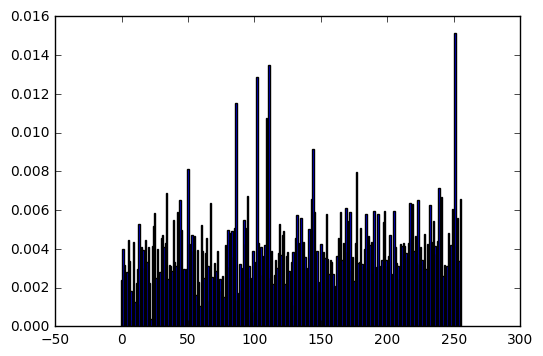

Entropy of distribution: 7.83957788115
Bins:
CudaNdarray([[-0.165627 1.075957 0.049782 -1.555640]
 [0.650808 0.211357 0.847001 0.707004]
 [-0.654891 -0.472890 -0.492466 0.707837]
 ..., 
 [0.418630 0.100451 0.168324 0.503950]
 [0.972543 0.988526 1.392234 0.400419]
 [0.354197 0.655790 0.884552 0.777753]])


In [32]:
if (K.get_value(QUANTIZATION_ON) > 0):
    probs = np.reshape(all_embed, (all_embed.shape[0] * all_embed.shape[1], NBINS))
    hist = np.sum(probs, axis = 0)
    hist /= np.sum(hist)

    sample_hist_bins = np.linspace(0, NBINS - 1, NBINS)
    plt.bar(sample_hist_bins, hist, align = 'center', width = 1)
    plt.show()

    entropy = 0
    for i in hist:
        if (i < 1e-4): continue
        entropy += i * math.log(i, 2)
    entropy = -entropy
    print "Entropy of distribution:", entropy

    print "Bins:"
    print QUANT_BINS.eval()

In [33]:
[rate, data] = sciwav.read("./SA1.wav")
data = data.astype(np.float32)
processedWave, wparams = preprocess_waveform(data)
windows = extract_windows(processedWave, STEP_SIZE, OVERLAP_SIZE)

transformed = np.reshape(windows, (windows.shape[0], WINDOW_SIZE, 1))
[embed, side] = encoder.predict(transformed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


In [34]:
recons = decoder.predict([embed, side], batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


In [35]:
print np.max(embed[25], axis = -1)

[1.000000 1.000000 0.999985 0.999960 1.000000 1.000000 1.000000 0.999993
 0.999810 1.000000 1.000000 0.997184 1.000000 1.000000 0.999993 0.999898
 1.000000 1.000000 0.999997 1.000000 0.999063 1.000000 0.758421 1.000000
 0.557337 0.985992 1.000000 0.871468 1.000000 0.910268 0.966752 1.000000
 1.000000 1.000000 1.000000 1.000000 0.902435 1.000000 1.000000 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 0.999784 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 0.552313]


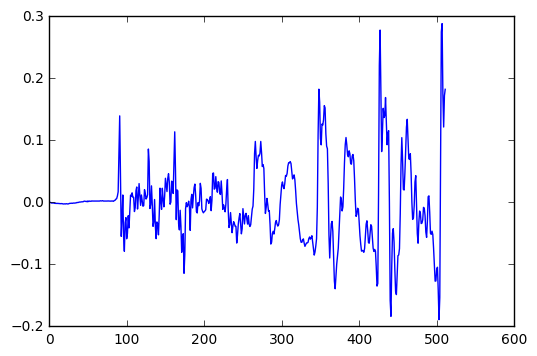

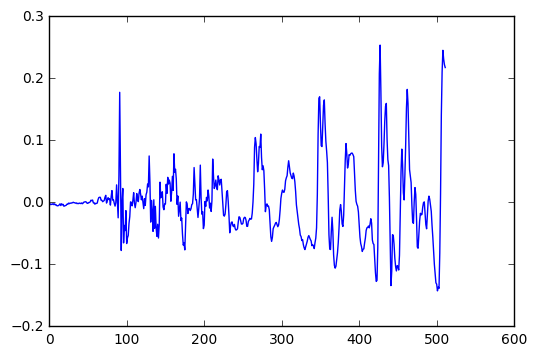

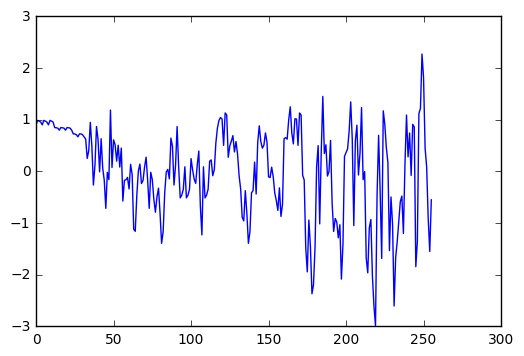

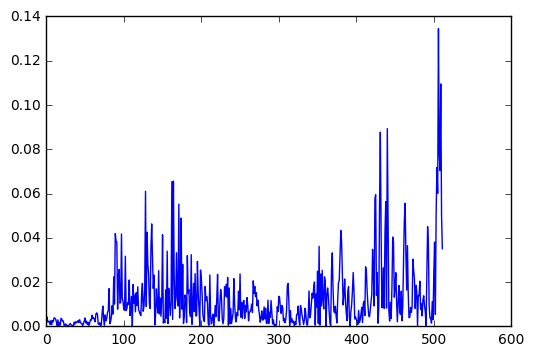

In [36]:
idx = 25

orig = windows[idx].flatten()
recn = recons[idx].flatten()

plt.plot(orig)
ylim = plt.gca().get_ylim()
plt.show()

plt.plot(recn)
plt.ylim(ylim)
plt.show()

if (K.get_value(QUANTIZATION_ON) > 0):
    code_vec = np.eye(NBINS)[np.argmax(embed[idx], axis = -1)]
    code_vec = unquantize_vec(code_vec).eval()
    plt.plot(code_vec)
else:
    code_vec = embed[idx][:, :VEC_SIZE].flatten()
    plt.plot(code_vec)
plt.show()

plt.plot(abs(orig - recn))
plt.show()